# Тестирование со стандартным датасетом

In [38]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import os
import librosa
import numpy as np
import torch
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pydub import AudioSegment
import io
import soundfile as sf
import matplotlib.pyplot as plt


In [39]:
FAKE = "data/fake/"
REAL = "data/real/"
REAL_CMP = "data/compressed/real/"
FAKE_CMP = "data/compressed/fake/"

In [40]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /facebook/wav2vec2-base/resolve/main/preprocessor_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: bc28d4aa-c1f4-449e-8bf3-aa05e1a7afdb)')' thrown while requesting HEAD https://huggingface.co/facebook/wav2vec2-base/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /facebook/wav2vec2-base/resolve/main/preprocessor_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: e8ceac6d-ae32-48ec-861c-0d7aba07046b)')' thrown while requesting HEAD https://huggingface.co/facebook/wa

In [41]:
device = torch.device("cuda")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base", dtype=torch.float16, attn_implementation="flash_attention_2").to(device)

/media/maksim/01D9C0870F4E7BE0/Code/courseproject/.venv/lib/python3.12/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [42]:
def compress_audio(audio_path):
    audio = AudioSegment.from_file(audio_path)
    
    current_dir = os.path.dirname(audio_path)
    parent_dir = os.path.dirname(current_dir)
    category = os.path.basename(current_dir)
    filename = os.path.basename(audio_path)
    
    filename_ogg = os.path.splitext(filename)[0] + ".ogg"
    
    compressed_root = os.path.join(parent_dir, "compressed", category)
    
    os.makedirs(compressed_root, exist_ok=True)
    
    save_path = os.path.join(compressed_root, filename_ogg)
    
    audio.export(save_path, format="ogg", codec="libopus", parameters=["-b:a", "16k"])
    
    buffer = io.BytesIO()
    audio.export(buffer, format="ogg", codec="libopus", parameters=["-b:a", "16k"])
    buffer.seek(0)
    
    return sf.read(buffer)

def load_audio_files(fake_folder, real_folder, need_to_compress=False):
    audio_data = []
    labels = []

    for filename in os.listdir(fake_folder):
        filepath = os.path.join(fake_folder, filename)
        audio, _ = compress_audio(filepath) if need_to_compress else librosa.load(filepath, sr=16000, duration=2) 
        audio_data.append(audio)
        labels.append(1)

    for filename in os.listdir(real_folder):
        filepath = os.path.join(real_folder, filename)
        audio, _ = compress_audio(filepath) if need_to_compress else librosa.load(filepath, sr=16000, duration=2) 
        audio_data.append(audio)
        labels.append(0)

    return audio_data, np.array(labels)

def extract_feat(audio_data):
    model.eval()
    features = []
    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype
    for audio in audio_data:
        inputs = feature_extractor(
                audio, 
                sampling_rate=16000, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, 
                max_length=2*16000
            )
        with torch.no_grad():
            outputs = model(inputs.input_values.to(device, dtype=dtype))
        feat = outputs.last_hidden_state.mean(dim=1)
        features.append(feat.cpu().numpy())

    return np.vstack(features) 



In [43]:
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base", dtype=torch.float16, attn_implementation="flash_attention_2").to(device)

In [44]:
audio_data, labels = load_audio_files(FAKE, REAL)
features = extract_feat(audio_data)
features.shape

(14356, 768)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels)

In [46]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",100
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None


In [47]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2154
           1       0.97      0.97      0.97      2153

    accuracy                           0.97      4307
   macro avg       0.97      0.97      0.97      4307
weighted avg       0.97      0.97      0.97      4307



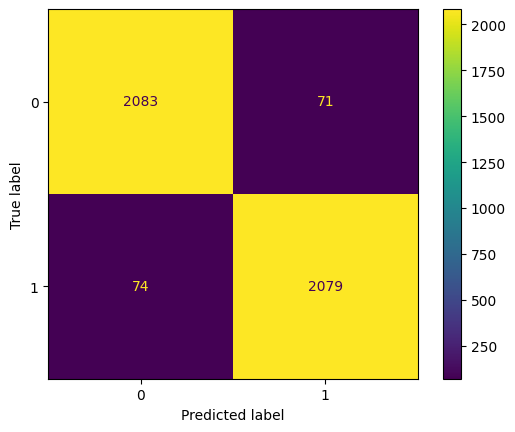

In [48]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Тест на сжатом аудио

In [49]:
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base", dtype=torch.float16, attn_implementation="flash_attention_2").to(device)

/media/maksim/01D9C0870F4E7BE0/Code/courseproject/.venv/lib/python3.12/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [50]:
audio_data, labels = load_audio_files(FAKE_CMP, REAL_CMP)
features_cmp = extract_feat(audio_data)

In [51]:
X_train_cmp, X_test_cmp, y_train_cmp, y_test_cmp = train_test_split(features_cmp, labels, test_size=0.3, stratify=labels)


In [52]:
clf_cmp = AdaBoostClassifier(n_estimators=100)
clf_cmp.fit(X_train_cmp, y_train_cmp)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",100
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None


In [53]:
y_pred_cmp = clf_cmp.predict(X_test_cmp)
print(classification_report(y_test_cmp, y_pred_cmp))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2153
           1       0.95      0.96      0.95      2154

    accuracy                           0.95      4307
   macro avg       0.95      0.95      0.95      4307
weighted avg       0.95      0.95      0.95      4307



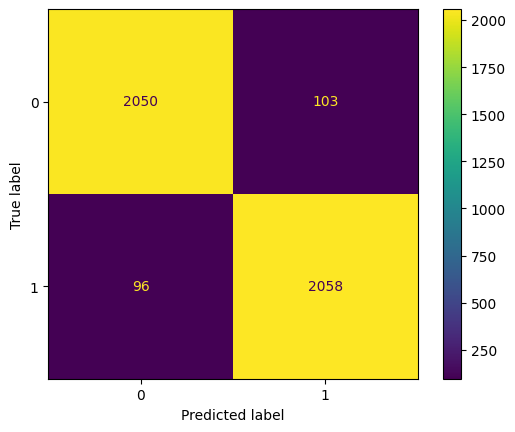

In [54]:
cm_cmp = confusion_matrix(y_test_cmp, y_pred_cmp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cmp)
disp.plot()
plt.show()

# Мелспектрограмма

In [55]:
def extract_mel_feat(audio_list, sr=16000):
    mel_features = []
    
    for audio in audio_list:
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        mel_features.append(np.mean(mel_db, axis=1))
        
    return np.array(mel_features)

In [56]:
audio_data, labels = load_audio_files(FAKE, REAL)
mel_features = extract_mel_feat(audio_data)

In [57]:
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(mel_features, labels, test_size=0.3)

In [58]:
clf_mel = AdaBoostClassifier(n_estimators=100)
clf_mel.fit(X_train_mel, y_train_mel)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",100
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None


In [60]:
y_pred_mel = clf_mel.predict(X_test_mel)
print(classification_report(y_test_mel, y_pred_mel))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2171
           1       0.93      0.93      0.93      2136

    accuracy                           0.93      4307
   macro avg       0.93      0.93      0.93      4307
weighted avg       0.93      0.93      0.93      4307



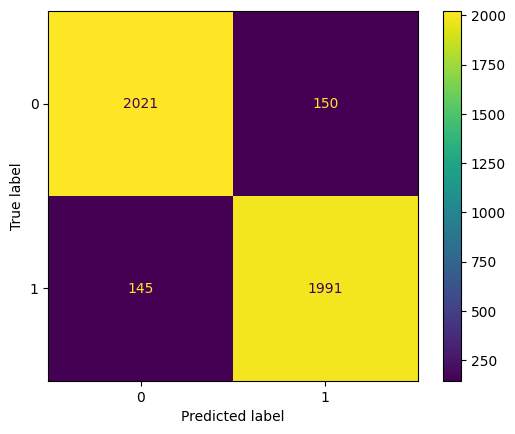

In [61]:
cm_mel = confusion_matrix(y_test_mel, y_pred_mel)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mel)
disp.plot()
plt.show()

# Мелспектрограмма со сжатым аудио

In [62]:
audio_comp, labels_comp = load_audio_files(FAKE_CMP, REAL_CMP)


In [63]:
features_mel_cmp = extract_mel_feat(audio_comp)
X_train_mel_cmp, X_test_mel_cmp, y_train_mel_cmp, y_test_mel_cmp = train_test_split(features_mel_cmp, labels, test_size=0.3, stratify=labels)


In [64]:
clf_mel_cmp = AdaBoostClassifier(n_estimators=100)
clf_mel_cmp.fit(X_train_mel_cmp, y_train_mel_cmp)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",None
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",100
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None


In [65]:
y_pred_mel_cmp = clf_mel_cmp.predict(X_test_mel_cmp)
print(classification_report(y_test_mel_cmp, y_pred_mel_cmp))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2153
           1       0.88      0.87      0.87      2154

    accuracy                           0.88      4307
   macro avg       0.88      0.88      0.88      4307
weighted avg       0.88      0.88      0.88      4307



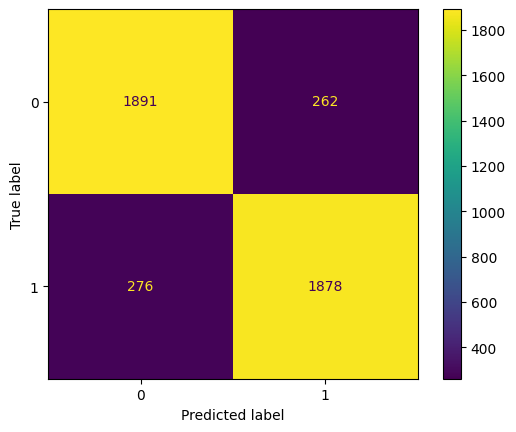

In [66]:
cm_mel_cmp = confusion_matrix(y_test_mel_cmp, y_pred_mel_cmp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mel_cmp)
disp.plot()
plt.show()